In [4]:
import numpy as np
import random
random.seed(666)
np.random.seed(666)
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.special import logsumexp
from scipy.stats import multivariate_normal
from scipy import optimize
from sklearn.mixture import GaussianMixture

import torch
from torch.autograd import grad
torch.manual_seed(666)
torch.set_default_dtype(torch.double)

from clusterless import preprocess
from sklearn.metrics import accuracy_score, roc_auc_score

### Data

In [5]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016/cavi_results/'

In [6]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
motion_energy, wheel_velocity, wheel_speed, paw_speed, nose_speed, pupil_diameter = preprocess.preprocess_dynamic_behaviors(behave_dict)

In [7]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [8]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]

rand_idx = np.arange(n_trials)
train_idx = rand_idx[:int(.8*n_trials)]
test_idx = rand_idx[int(.8*n_trials):]

train_y = wheel_velocity[train_idx]
test_y = wheel_velocity[test_idx]

In [9]:
n_time_bins = 30
binning = np.arange(0, 1.5, step=(1.5 - 0)/n_time_bins)
n_trials = stim_on_times.shape[0]
spike_train = np.concatenate(unsorted_trials)[:,[0,2,3,4]]

In [10]:
trial_idx = []
time_idx = []
all_trials = []
for k in range(n_trials):
    mask = np.logical_and(spike_train[:,0] >= stim_on_times[k]-0.5,
                          spike_train[:,0] <= stim_on_times[k]+1
                         )
    trial = spike_train[mask,:]
    trial[:,0] = trial[:,0] - trial[:,0].min()
    time_bins = np.digitize(trial[:,0], binning, right=False)-1
    for t in range(n_time_bins):
        time_bin = trial[time_bins == t, 1:]
        time_idx.append(np.ones_like(time_bin[:,0]) * t)
        trial_idx.append(np.ones_like(time_bin[:,0]) * k)
        all_trials.append(time_bin)
time_idx = np.concatenate(time_idx)
trial_idx = np.concatenate(trial_idx)
all_trials = np.concatenate(all_trials)

In [11]:
train_mask = np.sum([trial_idx == idx for idx in train_idx], axis=0).astype(bool)
train_trials = all_trials[train_mask]
train_time_idx = time_idx[train_mask]
train_trial_idx = trial_idx[train_mask]

test_mask = np.sum([trial_idx == idx for idx in test_idx], axis=0).astype(bool)
test_trials = all_trials[test_mask]
test_time_idx = time_idx[test_mask]
test_trial_idx = trial_idx[test_mask]

pre-compute mu and cov from training trials

In [12]:
C = 5
gmm = GaussianMixture(n_components=C, 
                      covariance_type='full', 
                      init_params='k-means++',
                      verbose=1)
gmm.fit(train_trials)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


GaussianMixture(init_params='k-means++', n_components=5, verbose=1)

In [13]:
# init_gmm = {
#     'weights': gmm.weights_,
#     'mu': gmm.means_,
#     'cov': gmm.covariances_,
# }
# np.save(save_path + f'init_gmm_c{C}_t{n_time_bins}.npy', init_gmm)

how to initialize lambda?

### ELBO

In [14]:
def safe_log(x, minval=1e-10):
    return torch.log(x + minval)

In [15]:
def compute_elbo(s, r, mu, cov, lam, k_idxs, t_idxs, K, T, C):

    # expected log-likelihood ( E_q(z)[log p(s,z|y)] )
    # sum_{ktij} r_{ijt}^k * log(dN(s_i^kt; mu_j, cov_j))
    
    # sum_{ktij} r_{ijt}^k * ( log(lambda_jt^(k)) - log(sum_j' lambda_j't^(k)) ) 
    elbo_1 = 0; log_dens = []
    for j in range(C):
        log_dens.append(
            torch.tensor(
                multivariate_normal.logpdf(s, mu[j], cov[j])
            )
        )
        elbo_1 += torch.einsum('i,i->', r[:,j], log_dens[-1])
      
    # einsum is slower
    elbo_2 = torch.tensor([ 
                torch.sum( r[np.intersect1d(k_idxs[k], t_idxs[t])] * norm_lam[k,:,t] ) \
                for t in range(T) for k in range(K)
             ]).sum()
        
    # entropy of q(z) ( E_q(z)[log q(z)] )
    # sum_{ktij} log(r_{ijt}^k) * r_{ijt}^k
    elbo_3 = - torch.einsum('ij,ij->', safe_log(r), r)
    
    elbo = elbo_1 + elbo_2 + elbo_3 
    
    print(f'elbo 1: {elbo_1}')
    print(f'elbo 2: {elbo_2}')
    print(f'elbo 3: {elbo_3}')
    
    return elbo, torch.vstack(log_dens).T

In [16]:
K = len(train_idx)
C = len(gmm.means_)
T = n_time_bins

s = torch.tensor(train_trials)
r = torch.ones((train_trials.shape[0], C)) / C
k_idxs = [torch.argwhere(torch.tensor(train_trial_idx) == k).reshape(-1) for k in range(K)]
t_idxs = [torch.argwhere(torch.tensor(train_time_idx) == t).reshape(-1) for t in range(T)]

y_k = torch.tensor(train_y)
y = torch.zeros((train_trials.shape[0], T))
for k in range(K):
    y[torch.tensor(train_trial_idx) == k,:] = y_k[k]

b = torch.normal(0, 1, size=(C,))
beta = torch.normal(0, 1, size=(C,T,T))

init_lam = torch.zeros((K,C,T))
for k in range(K):
    for t in range(T):
        init_lam[k,:,t] = torch.exp(b + beta[:,t,:] @ y_k[k])
norm_lam = safe_log(init_lam) - safe_log(init_lam.sum(1)[:,None,:])

In [199]:
%%time
elbo, log_dens = compute_elbo(s=s, 
                    r=r, 
                    mu=gmm.means_, 
                    cov=gmm.covariances_, 
                    lam=init_lam, 
                    k_idxs=k_idxs,
                    t_idxs=t_idxs,
                    K=len(train_idx),
                    T=n_time_bins,
                    C=len(gmm.means_))
print(elbo)

elbo 1: -115223206.2406357
elbo 2: -7736824.149074271
elbo 3: 1368129.286682262
tensor(-1.2159e+08)
CPU times: user 5.73 s, sys: 196 ms, total: 5.93 s
Wall time: 2.88 s


### Update $b_j$ and $\beta_{jt}$

In [17]:
b = torch.normal(0, 1, size=(C,)).requires_grad_(True)
beta = torch.normal(0, 1, size=(C,T,T))

#### 1) find $b_j$

In [34]:
def safe_grad_bj(b_j, j, b_no_j, beta, y_k, r, k_idxs, t_idxs):
    val = 0
    for k in range(len(k_idxs)):
        for t in range(len(t_idxs)):
            k_t_idx = np.intersect1d(k_idxs[k], t_idxs[t])
            num = b_j + beta[j,t,:] @ y_k[k]
            denom = torch.logsumexp(torch.hstack([b_j, b_no_j]) + beta[:,t,:] @ y_k[k], 0)
            val += torch.sum( r[k_t_idx, j] * ( 1 - torch.exp(num - denom) ) )
    return val

In [35]:
j = 3
no_j = torch.cat([torch.arange(j), torch.arange(j+1,C)])
b_j = b[j]
b_no_j = b[no_j]
safe_grad_bj(b_j, 3, b_no_j, beta, y_k, r, k_idxs, t_idxs)

tensor(101833.2361, grad_fn=<AddBackward0>)

In [36]:
def grad_bj(b_j, j, b_no_j, beta, y_k, r, k_idxs, t_idxs):
    val = 0
    for k in range(len(k_idxs)):
        for t in range(len(t_idxs)):
            k_t_idx = np.intersect1d(k_idxs[k], t_idxs[t])
            val += torch.sum( r[k_t_idx, j] * \
                (1 - ( torch.exp(b_j + beta[j,t,:] @ y_k[k]) / \
                      (torch.exp(torch.hstack([b_j, b_no_j]) + beta[:,t,:] @ y_k[k])).sum() ) )
                )
    return val

In [37]:
j = 3
no_j = torch.cat([torch.arange(j), torch.arange(j+1,C)])
b_j = b[j]
b_no_j = b[no_j]
grad_bj(b_j, 3, b_no_j, beta, y_k, r, k_idxs, t_idxs)

tensor(101833.2361, grad_fn=<AddBackward0>)

In [95]:
def newton_bj(j, b, beta, y_k, r, k_idxs, t_idxs, eps=1e-6, max_iter=1000):
    b_j_new = b[j]
    no_j = torch.cat([torch.arange(j), torch.arange(j+1, len(b))])
    b_no_j = b[no_j]
    
    for i in range(max_iter):
        f = safe_grad_bj(b_j_new, j, b_no_j, beta, y_k, r, k_idxs, t_idxs)
        if abs(f) < eps:
            print(f'grad at b_{j} = {b_j_new:.2f} is {f.item():.2f}')
            return b_j_new.item()
        
        Df = grad(outputs=f, inputs=b_j_new)[0]
        if Df == 0:
            print('no solution found (0 derivative).')
            return b[j].item()
        b_j_new = b_j_new - f / Df
        
        if (i % 10) == 0:
            print(f'grad at b_{j} = {b_j_new:.2f} is {f.item():.2f}')
    print('exceeded max iter. no solution found.')
    
    return b[j]

In [39]:
newton_bj(1, b, beta, y_k, r, k_idxs, t_idxs)

grad at b_1 = 4.02 is 92887.55
grad at b_1 = 1.86 is 0.00


1.8628824473149748

#### 2) find $\beta_{jtl}$

In [92]:
def safe_grad_beta_jtl(beta_jtl, j, t, l, beta_jt_no_l, beta_no_jt, b, y_k, r, k_idxs, t_idxs):
    val = 0
    no_j = np.concatenate([np.arange(j), np.arange(j+1,len(b))])
    no_l = np.concatenate([np.arange(l), np.arange(l+1,len(t_idxs))])
    for k in range(len(k_idxs)):
        k_t_idx = np.intersect1d(k_idxs[k], t_idxs[t])
        num = b[j] + beta_jtl * y_k[k][l] + beta_jt_no_l @ y_k[k][no_l]
        x = b[no_j] + beta_no_jt @ y_k[k]
        y = (b[j] + np.hstack([beta_jtl, beta_jt_no_l]) @ \
             np.hstack([y_k[k][l], y_k[k][no_l]])).reshape(-1)
        denom = logsumexp(np.hstack([x, y]), 0)
        val += ( r[k_t_idx, j, None] * y_k[k][l] * ( 1 - np.exp(num - denom) ) ).sum()
    return val

In [93]:
j = 3; t = 5; l = 1
no_j = torch.cat([torch.arange(j), torch.arange(j+1, len(b))])
no_t = torch.cat([torch.arange(t), torch.arange(t+1, len(t_idxs))])
no_l = torch.cat([torch.arange(l), torch.arange(l+1,len(t_idxs))])
beta_jtl = beta[j,t,l]
beta_jt_no_l = beta[j,t,no_l]
beta_no_j_t = beta[no_j][:,t]

res = [safe_grad_beta_jtl(beta_jtl.detach().numpy(), 
                     j, t, l, 
                     beta_jt_no_l.detach().numpy(), 
                     beta_no_j_t.detach().numpy(), 
                     b.detach().numpy(), 
                     y_k.detach().numpy(), 
                     r.detach().numpy(), 
                     k_idxs, t_idxs) for l in range(len(t_idxs))]

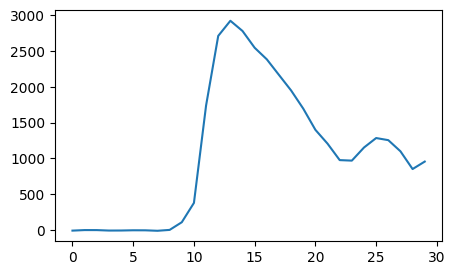

In [94]:
plt.figure(figsize=(5,3))
plt.plot(res);

In [82]:
def grad_beta_jtl(beta_jtl, j, t, l, beta_jt_no_l, beta_no_jt, b, y_k, r, k_idxs, t_idxs):
    val = 0
    no_j = np.concatenate([np.arange(j), np.arange(j+1,len(b))])
    no_l = np.concatenate([np.arange(l), np.arange(l+1,len(t_idxs))])
    for k in range(len(k_idxs)):
        k_t_idx = np.intersect1d(k_idxs[k], t_idxs[t])
        val += ( r[k_t_idx, j, None] * y_k[k][l] * \
            (1 - ( np.exp(b[j] + beta_jtl * y_k[k][l] + beta_jt_no_l @ y_k[k][no_l]) / \
                  ((np.exp(b[no_j, None] + beta_no_jt @ y_k[k])).sum() + \
                    np.exp(b[j] + beta_jtl * y_k[k][l] + beta_jt_no_l @ y_k[k][no_l]) ) ) )
            ).sum(0)
    return val

In [89]:
j = 3; t = 5; l = 1
no_j = torch.cat([torch.arange(j), torch.arange(j+1, len(b))])
no_t = torch.cat([torch.arange(t), torch.arange(t+1, len(t_idxs))])
no_l = torch.cat([torch.arange(l), torch.arange(l+1,len(t_idxs))])
beta_jtl = beta[j,t,l]
beta_jt_no_l = beta[j,t,no_l]
beta_no_j_t = beta[no_j][:,t]

res = [grad_beta_jtl(beta_jtl.detach().numpy(), 
                     j, t, l, 
                     beta_jt_no_l.detach().numpy(), 
                     beta_no_j_t.detach().numpy(), 
                     b.detach().numpy(), 
                     y_k.detach().numpy(), 
                     r.detach().numpy(), 
                     k_idxs, t_idxs) for l in range(len(t_idxs))]

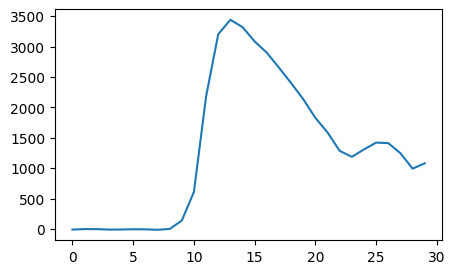

In [90]:
plt.figure(figsize=(5,3))
plt.plot(res);

In [108]:
optimize.root(grad_beta_jtl, beta_jtl.detach().numpy(),
       args=(j, t, l, beta_jt_no_l.detach().numpy(), 
             beta_no_jt.detach().numpy(),
             b.detach().numpy(), y_k.detach().numpy(), 
             r.detach().numpy(), k_idxs, t_idxs), method='hybr')

    fjac: array([[-1.]])
     fun: array([-3.33066907e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.4182322e-11])
       r: array([0.00823858])
  status: 1
 success: True
       x: array([-215.5655483])

In [36]:
for j in [2]:
    for t in [0]:
        for l in [9]:
            no_j = torch.cat([torch.arange(j), torch.arange(j+1, len(b))])
            no_t = torch.cat([torch.arange(t), torch.arange(t+1, len(t_idxs))])
            no_l = torch.cat([torch.arange(l), torch.arange(l+1,len(t_idxs))])

            init_guess = np.linspace(-500, -100, 100)
            inputs = (j, t, l, 
                       beta[j,t,no_l].detach().numpy(), 
                       beta[no_j][:,no_t].detach().numpy(),
                       b.detach().numpy(), 
                       y_k.detach().numpy(), 
                       r.detach().numpy(), 
                       k_idxs, t_idxs
                      )
            sol = optimize.root(grad_beta_jtl, beta[j,t,l].detach().numpy(), 
                                            args = inputs, method='hybr')
            beta[j,t,l] = sol.x[0]
            res = sol.fun[0]
            print(f'grad at beta (j = {j}, t = {t}, l = {l}) : {beta[j,t,l]:.2f} is {res:.2f}.')
            counter = 0
            while not np.allclose(res, 0): 
                sol = optimize.root(grad_beta_jtl, init_guess[counter], args = inputs, method='hybr')
                beta[j,t,l] = sol.x[0]
                res = sol.fun[0]
                counter += 1
                print(f'grad at beta (j = {j}, t = {t}, l = {l}) : {beta[j,t,l]:.2f} is {res:.2f}.')

grad at beta (j = 2, t = 0, l = 9) : 145.29 is -0.00.


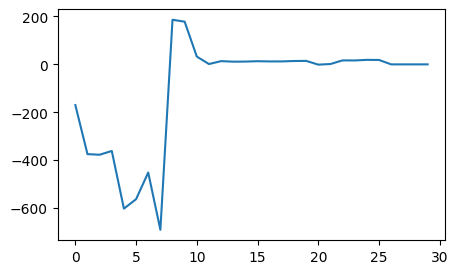

In [120]:
plt.figure(figsize=(5,3))
plt.plot(beta_new[0,2]);

#### CAVI

In [110]:
def cavi(s, y_k, means, covs, K, T, C, D, k_idxs, t_idxs, max_iter=20, eps=1e-10):
    
    # initialize
    r = torch.ones((s.shape[0], C)) / C
    mu, cov = torch.tensor(means), torch.tensor(covs)
    b = torch.normal(0, 1, size=(C,)).requires_grad_(True)
    beta = torch.normal(0, 1, size=(C,T,T))

    lam = torch.zeros((K,C,T))
    for k in range(K):
        for t in range(T):
            lam[k,:,t] = torch.exp(b + beta[:,t,:] @ y_k[k])
    norm_lam = safe_log(lam) - safe_log(lam.sum(1)[:,None,:])
    
    # compute ELBO
    elbo, log_dens = compute_elbo(s, r, mu, cov, lam, k_idxs, t_idxs, K, T, C)
    convergence = 1.
    elbos = [elbo]
    print(f'initial elbo: {elbos[-1]:.2f}')
    
    it = 1
    while convergence > eps or convergence < 0:  # while ELBO not converged   
        # update q(z)
        # r_{ijt}^k = rho_{ijt}^k / sum_j rho_{ijt}^k
        # rho_{ijt}^k = exp( log(dN(s_i^kt; mu_j, cov_j)) + 
        #                      ( log(lambda_jt^(k)) - log(sum_j' lambda_j't^(k)) ) )    
        for k in range(K):
            for t in range(T):
                k_t_idx = np.intersect1d(k_idxs[k], t_idxs[t])
                r[k_t_idx] = torch.exp(log_dens[k_t_idx] + norm_lam[k,:,t])
                r[k_t_idx] = torch.einsum('ij,i->ij', r[k_t_idx], 1/r[k_t_idx].sum(1))
            
        
        # update beta
        # beta_new = torch.zeros_like(beta)
        for j in range(C):
            no_j = torch.cat([torch.arange(j), torch.arange(j+1, len(b))])
            for t in range(T):
                no_t = torch.cat([torch.arange(t), torch.arange(t+1, len(t_idxs))])
                for l in range(T):
                    no_l = torch.cat([torch.arange(l), torch.arange(l+1,len(t_idxs))])
                    
                    inputs = (j, t, l, 
                               beta[j,t,no_l].detach().numpy(), 
                               beta[no_j][:,t].detach().numpy(),
                               b.detach().numpy(), 
                               y_k.detach().numpy(), 
                               r.detach().numpy(), 
                               k_idxs, t_idxs
                              )
                    sol = optimize.root(safe_grad_beta_jtl, beta[j,t,l].detach().numpy(), 
                                                    args = inputs, method='hybr')
                    beta[j,t,l] = sol.x[0]
                    res = sol.fun
                    counter = 0
                    init_guess = sol.x[0]-250.
                    while not np.allclose(res, 0): 
                        # if np.abs(res) < 50:
                        #     init_guess += 1e-1
                        # elif np.abs(res) < 1:
                        #     init_guess += 1e-2
                        # elif np.abs(res) < .2:
                        #     # hard-coding
                        #     res = 0
                        # else:
                        #     init_guess += 10.
                        init_guess += 10.
                        sol = optimize.root(safe_grad_beta_jtl, init_guess, args = inputs, method='hybr')
                        beta[j,t,l] = sol.x[0]
                        res = sol.fun[0]
                        # beta[j,t,l] = init_guess
                        # res = safe_grad_beta_jtl(init_guess, 
                        #                    j, t, l, 
                        #                    beta[j,t,no_l].detach().numpy(), 
                        #                    beta[no_j][:,t].detach().numpy(),
                        #                    b.detach().numpy(), 
                        #                    y_k.detach().numpy(), 
                        #                    r.detach().numpy(), 
                        #                    k_idxs, t_idxs).item()
                        counter += 1
                        print(f'grad at beta (j = {j}, t = {t}, l = {l}) : {beta[j,t,l]:.2f} is {res:.2f}.')
                    if np.logical_and((t+1) % 1 == 0, (l+1) % 1 == 0):
                        print(f'grad at beta (j = {j}, t = {t}, l = {l}) : {beta[j,t,l]:.2f} is {res:.2f}.')
        # beta = beta_new.clone()
        
        
        # update b 
        # FIX: order of update
        b_new = torch.zeros_like(b)
        for j in range(C):
            b_new[j] = newton_bj(j, b, beta, y_k, r, k_idxs, t_idxs)
        b = b_new.clone().requires_grad_(True)
            
        
        # compute lambda's
        for k in range(K):
            for t in range(T):
                lam[k,:,t] = torch.exp(b + beta[:,t,:] @ y_k[k])
        norm_lam = safe_log(lam) - safe_log(lam.sum(1)[:,None,:]) 
        
        
        # update means and covs
        norm = r.sum(0)
        mu = torch.einsum('j,ij,ip->jp', 1/norm, r, s)
        cov = [torch.einsum(
            ',i,ip,id->pd', 1/norm[j], r[:,j], s-mu[j], s-mu[j] 
            ) for j in range(C)]
        
        # compute ELBO
        elbo, log_dens = compute_elbo(s, r, mu, cov, lam, k_idxs, t_idxs, K, T, C)
        elbos.append(elbo)
        convergence = elbos[-1] - elbos[-2]
        
        print(f'iter: {it} elbo: {elbos[-1]:.2f}.')
        it +=1 
        if it > max_iter: 
            print('reached max iter allowed.')
            break
            
    if abs(convergence) <= eps:
        print('converged.')
    
    return r, lam, b, beta, mu, cov, elbos

### Run

In [ ]:
%%time
enc_r, enc_lam, enc_b, enc_beta, enc_mu, enc_cov, enc_elbo = cavi(
                                                    s=s, 
                                                    y_k=y_k, 
                                                    means=gmm.means_, 
                                                    covs=gmm.covariances_, 
                                                    K=len(train_idx), 
                                                    T=n_time_bins, 
                                                    C=len(gmm.means_), 
                                                    D=train_trials.shape[1], 
                                                    k_idxs=k_idxs,
                                                    t_idxs=t_idxs, 
                                                    max_iter=2)

elbo 1: -120315906.67333016
elbo 2: -5870987.152173714
elbo 3: 956281.3335645112
initial elbo: -125230612.49
grad at beta (j = 0, t = 0, l = 0) : -9.29 is -0.00.
grad at beta (j = 0, t = 0, l = 1) : -25.68 is 0.00.
grad at beta (j = 0, t = 0, l = 2) : -23.43 is 0.00.
grad at beta (j = 0, t = 0, l = 3) : -17.72 is 0.00.
grad at beta (j = 0, t = 0, l = 4) : -41.30 is -0.00.
grad at beta (j = 0, t = 0, l = 5) : 13.28 is 0.00.
grad at beta (j = 0, t = 0, l = 6) : 29.74 is -0.00.
grad at beta (j = 0, t = 0, l = 7) : 5.13 is 0.00.
grad at beta (j = 0, t = 0, l = 8) : -6.36 is -0.00.
grad at beta (j = 0, t = 0, l = 9) : 16.43 is 0.00.
grad at beta (j = 0, t = 0, l = 10) : 0.69 is 0.00.
grad at beta (j = 0, t = 0, l = 11) : 0.42 is -0.00.
grad at beta (j = 0, t = 0, l = 12) : 0.65 is 0.00.
grad at beta (j = 0, t = 0, l = 13) : 0.50 is 0.00.
grad at beta (j = 0, t = 0, l = 14) : 0.96 is 0.00.
grad at beta (j = 0, t = 0, l = 15) : -1.25 is -0.00.
grad at beta (j = 0, t = 0, l = 16) : 1.14 is -0.

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(enc_elbo)
plt.xlabel('iteration')
plt.ylabel('ELBO')
pass